In [38]:
import scipy as sc
import imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

In [7]:
import os, json

In [1]:
path = "/home/zelenyy/storage/data/sri-satellite/BAT/proton/"

In [5]:
sims = list(filter(lambda x: x[:3]=="sim", os.listdir(path)))

In [10]:
res_parse= []
for sim in sims:
    path_deposit = os.path.join(path, sim, 'data/deposit.txt')
    path_meta = os.path.join(path, sim, 'meta.json')
    with open(path_meta, 'r') as pm:
        meta = json.load(pm)
    deposit = np.loadtxt(path_deposit)
    res_parse.append([meta['energy'], meta['number'], deposit])
    

In [12]:
res_parse

[[41, 10000, array([[  1.83382000e+00,   1.11899000e-02],
         [  1.90914000e+00,   1.04875000e-02],
         [  1.98499000e+00,   1.09860000e-02],
         [  2.07871000e+00,   1.12388000e-02],
         [  2.18985000e+00,   1.10037000e-02],
         [  2.33048000e+00,   1.15404000e-02],
         [  2.49791000e+00,   1.12949000e-02],
         [  2.70664000e+00,   1.18941000e-02],
         [  2.99588000e+00,   1.34450000e-02],
         [  3.40621000e+00,   1.65092000e-02],
         [  4.10117000e+00,   3.06154000e-02],
         [  5.70984000e+00,   2.07503000e-01],
         [  7.25442000e+00,   1.21967000e+00],
         [  9.35093000e-04,   1.73304000e-03],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00],
  

In [23]:
energy = np.array([i[0] for i in res_parse])
number = np.array([i[1] for i in res_parse])

In [34]:
mean = np.zeros((65, 100))
for i in range(100):
    indx = int(res_parse[i][0])
    mean[:,indx-1] = res_parse[i][2][:65,0] 

In [35]:
energy.sort()

<ErrorbarContainer object of 3 artists>

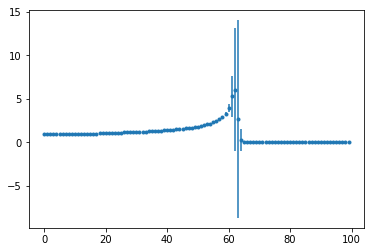

In [32]:


plt.errorbar(range(100), res_parse[9][2][:,0], yerr=res_parse[9][2][:,1], fmt='.')

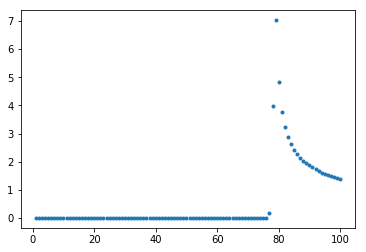

In [37]:
plt.plot(energy, mean[40], '.', )

In [39]:
inter = interp1d(energy, mean[10])

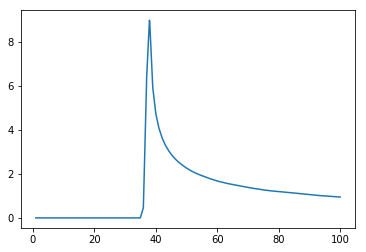

In [43]:
x = np.linspace(1,100,1000)
plt.plot(x, inter(x))

In [45]:
Kernels = [interp1d(energy, mean[i,:], kind='cubic') for i in range(65)]

def kernel(x, y):
    i = int(y)
    return Kernels[i](x)

In [46]:
import sys
sys.path.append('/home/zelenyy/npm/stats/statreg-py')

In [47]:
from statreg.deconvolution import GaussErrorMatrixUnfolder
from statreg.basis import CubicSplines

In [48]:
bas =CubicSplines(energy)

In [49]:
Kmn = bas.discretizeKernel(kernel, np.arange(65))

In [51]:
omega = bas.omega(2)

In [52]:
model = GaussErrorMatrixUnfolder(omega)

In [53]:
path = "/home/zelenyy/storage/data/sri-satellite/BAT/gauss/data/"

In [54]:
deposit = np.loadtxt(os.path.join(path, 'deposit.txt'), dtype=[("mean", 'd'), ('sigma', 'd')])
primary = np.loadtxt(os.path.join(path, 'primary.txt') )

In [58]:
from scipy.stats import norm

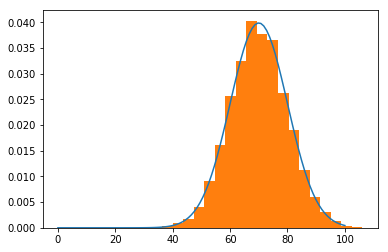

In [61]:
x = np.linspace(0,100,100)
plt.plot(x, norm.pdf(x, loc=70, scale=10))
plt.hist(primary, bins=20, density=True);

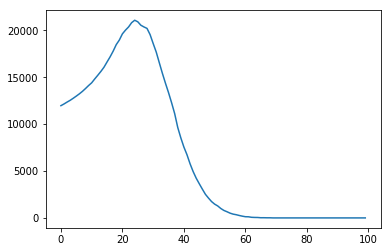

In [62]:
plt.plot(deposit['mean']*10000)

In [68]:
KmnR = np.round(Kmn, 3)

In [69]:
f = deposit['mean'][:65]*10000
sig = f**0.5
beamRes = model.solve(KmnR, f, sig)

/home/zelenyy/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:532: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[k] = func(sim[k])
/home/zelenyy/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:557: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxe
/home/zelenyy/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxcc


In [71]:
def phir(res):
    return  lambda x: sum([p*bf(x) for p, bf in zip(res.phi,bas.basisFun)])

In [72]:
phi = phir(beamRes)

In [76]:
from scipy.integrate import quad

In [78]:
norm = quad(phi, 0,100, limit=100)[0]

/home/zelenyy/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [81]:
import matplotlib as mpl


In [82]:
mpl.rcParams['font.size'] = 16

In [86]:
from statreg.vector import PhiVec

In [ ]:
beamRes.

In [88]:
phi = PhiVec(beamRes.phi, bas, sig= beamRes.covariance)

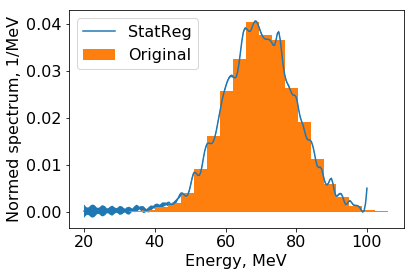

In [93]:
x = np.linspace(20,100, 200)
y = phi(x)/norm
dy = phi.error(x)/norm
plt.plot(x, phi(x)/norm, label = 'StatReg')
plt.fill_between(x, y-dy,y+dy)

plt.hist(primary, bins=20, density=True,label= 'Original')
plt.ylabel("Normed spectrum, 1/MeV")
plt.xlabel("Energy, MeV")
plt.legend();
plt.savefig('BeamDumping.svg', format='svg', trasparent=True);